<a href="https://colab.research.google.com/github/skyMei-J/Spark/blob/main/distributed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%env SPARK_DRIVER_MEMORY=4g

env: SPARK_DRIVER_MEMORY=4g


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

! java -version 2>&1 | awk -F[\"_] 'NR==1{print $2}'

openjdk version "1.8.0_292"
OpenJDK Runtime Environment (build 1.8.0_292-8u292-b10-0ubuntu1~18.04-b10)
OpenJDK 64-Bit Server VM (build 25.292-b10, mixed mode)
1.8.0


In [3]:
%tensorflow_version 1.x
!pip3 uninstall kapre
!pip3 install tensorflow==1.15
!pip3 install analytics-zoo 
!pip3 install numpy==1.18.5
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# You MUST use tensorflow 1.10.0
print(tf.__version__)

TensorFlow 1.x selected.
Uninstalling kapre-0.3.5:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/kapre-0.3.5.dist-info/*
    /usr/local/lib/python3.7/dist-packages/kapre/*
Proceed (y/n)? y
  Successfully uninstalled kapre-0.3.5
1.15.0


In [4]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [5]:

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [6]:

train_images.shape

(60000, 28, 28)

In [7]:

train_images2 = train_images[:20000]
train_labels2 = train_labels[:20000]

In [8]:
len(train_labels)

60000

In [9]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [10]:

test_images.shape

(10000, 28, 28)

In [11]:
len(test_labels)

10000

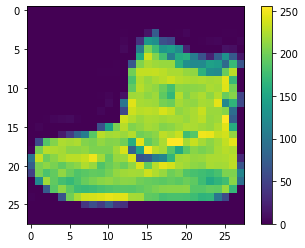

In [12]:

plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [13]:
train_images = train_images / 255.0
train_images2 = train_images2 / 255.0
test_images = test_images / 255.0

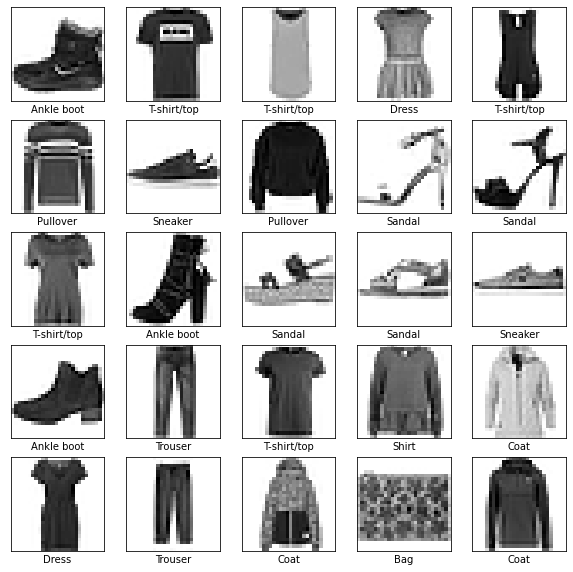

In [14]:

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [15]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [16]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
from zoo.tfpark import KerasModel, TFDataset
from zoo import init_nncontext
# set up enviroment
_ = init_nncontext()
# wrap model as tfpark model for distributted training, evaluation and prediction
model = KerasModel(model)

Prepending /usr/local/lib/python3.7/dist-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Adding /usr/local/lib/python3.7/dist-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.2-spark_2.4.3-0.10.0-jar-with-dependencies.jar to BIGDL_JARS
Prepending /usr/local/lib/python3.7/dist-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path

pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.7/dist-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.2-spark_2.4.3-0.10.0-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/lib/bigdl-0.12.2-jar-with-dependencies.jar pyspark-shell 


In [18]:
dataset = TFDataset.from_ndarrays((train_images, train_labels),
                                 batch_size=160,
                                 val_tensors=(test_images, test_labels))
model.fit(dataset, epochs=5, batch_size=160)





creating: createTFParkSampleToMiniBatch
creating: createZooKerasSparseCategoricalCrossEntropy
creating: createLoss
creating: createZooKerasSparseCategoricalAccuracy
creating: createFakeOptimMethod
Instructions for updating:
Use `tf.cast` instead.

creating: createTFValidationMethod
creating: createTFValidationMethod





creating: createTFTrainingHelper
creating: createIdentityCriterion
creating: createTFParkSampleToMiniBatch
creating: createTFParkSampleToMiniBatch
creating: createEstimator
creating: createMaxEpoch
creating: createEveryEpoch
INFO:tensorflow:Restoring parameters from /tmp/tmp1kfrp67s/model


In [19]:
eval_dist = model.evaluate(test_images, test_labels, batch_per_thread=280, distributed=True)
print(eval_dist)
print('Test accuracy:', eval_dist['acc Top1Accuracy'])


creating: createZooKerasAccuracy
creating: createStatelessMetric
creating: createTFValidationMethod
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'TFNdarrayDataset' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'TFNdarrayDataset' object has no attribute 'name'
INFO:tensorflow:SavedModel written to: /tmp/tmpas1m9to2/saved_model.pb
{'loss': 0.3699045181274414, 'ac

In [20]:
predictions = model.predict(test_images, batch_per_thread=280, distributed=True)

INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'TFNdarrayDataset' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'TFNdarrayDataset' object has no attribute 'name'
INFO:tensorflow:SavedModel written to: /tmp/tmpxwhm94z2/saved_model.pb


In [21]:
predictions[0]

array([1.18085836e-05, 1.13277885e-07, 1.88577760e-05, 3.18487109e-05,
       1.80283114e-05, 4.36577983e-02, 6.68067805e-05, 8.78340080e-02,
       9.69985384e-04, 8.67390811e-01], dtype=float32)

In [22]:
np.argmax(predictions[0])

9

In [23]:
test_labels[0]

9

In [24]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)
  
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

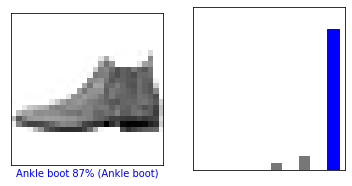

In [25]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

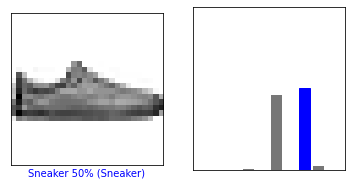

In [26]:

i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()


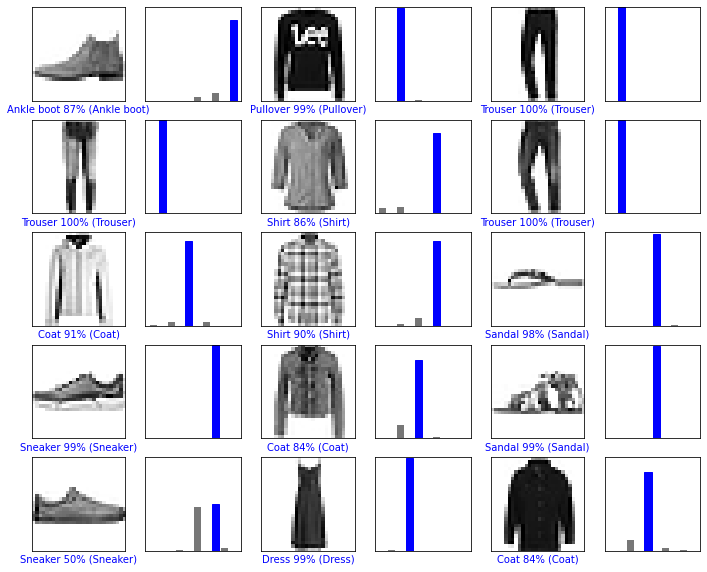

In [27]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)
plt.show()

In [28]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28)


In [29]:

# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


In [30]:

predictions_single = model.predict(img)

print(predictions_single)

[[1.1808581e-05 1.1327806e-07 1.8857789e-05 3.1848678e-05 1.8028324e-05
  4.3657854e-02 6.6806824e-05 8.7834083e-02 9.6998713e-04 8.6739057e-01]]


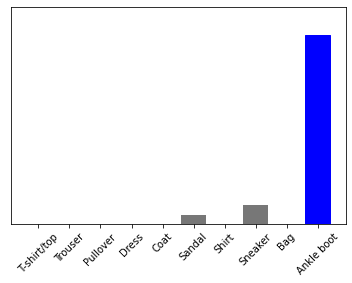

In [31]:
plot_value_array(0, predictions_single, test_labels)
plt.xticks(range(10), class_names, rotation=45)
plt.show()

In [32]:

prediction_result = np.argmax(predictions_single[0])
print(prediction_result)

9
